In [1]:
import pandas as pd
import numpy as np

import featuretools as ft


In [2]:
#!pip install --upgrade numpy pandas matplotlib seaborn woodwork featuretools scikit-learn pyarrow

In [3]:
#!pip install --upgrade dask distributed nodejs dask-labextension

In [4]:
app_train = pd.read_csv('./application_train.csv')
app_test = pd.read_csv('./application_test.csv')
bureau = pd.read_csv('./bureau.csv')
bureau_balance = pd.read_csv('./bureau_balance.csv')
cash = pd.read_csv('./POS_CASH_balance.csv')
credit = pd.read_csv('./credit_card_balance.csv')
previous = pd.read_csv('./previous_application.csv')
installments = pd.read_csv('./installments_payments.csv')

In [5]:
app_test['TARGET'] = np.nan
app = pd.concat([app_train, app_test], ignore_index=True, sort=True)

In [6]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df):
    """Convert pandas data types for memory reduction."""
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif set(df[c].unique()) == {0, 1}:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    return df

In [7]:
app = convert_types(app)
bureau = convert_types(bureau)
bureau_balance = convert_types(bureau_balance)
cash = convert_types(cash)
credit = convert_types(credit)
previous = convert_types(previous)
installments = convert_types(installments)

In [8]:
bureau_balance = bureau_balance.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], 
                                      on = 'SK_ID_BUREAU', how = 'left')

In [9]:
for dataset in [app, bureau, bureau_balance, cash, credit, previous, installments]:
    dataset.set_index('SK_ID_CURR', inplace = True)

In [10]:
def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

In [11]:
start_date = pd.Timestamp("2023-01-01")
start_date

Timestamp('2023-01-01 00:00:00')

In [12]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
SK_ID_CURR,,,,
215354,-497 days,-153 days,-153 days,-131 days
215354,-208 days,1075 days,NaT,-20 days
215354,-203 days,528 days,NaT,-16 days
215354,-203 days,NaT,NaT,-16 days
215354,-629 days,1197 days,NaT,-21 days


In [13]:
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

/tmp/ipykernel_136/3221545483.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);


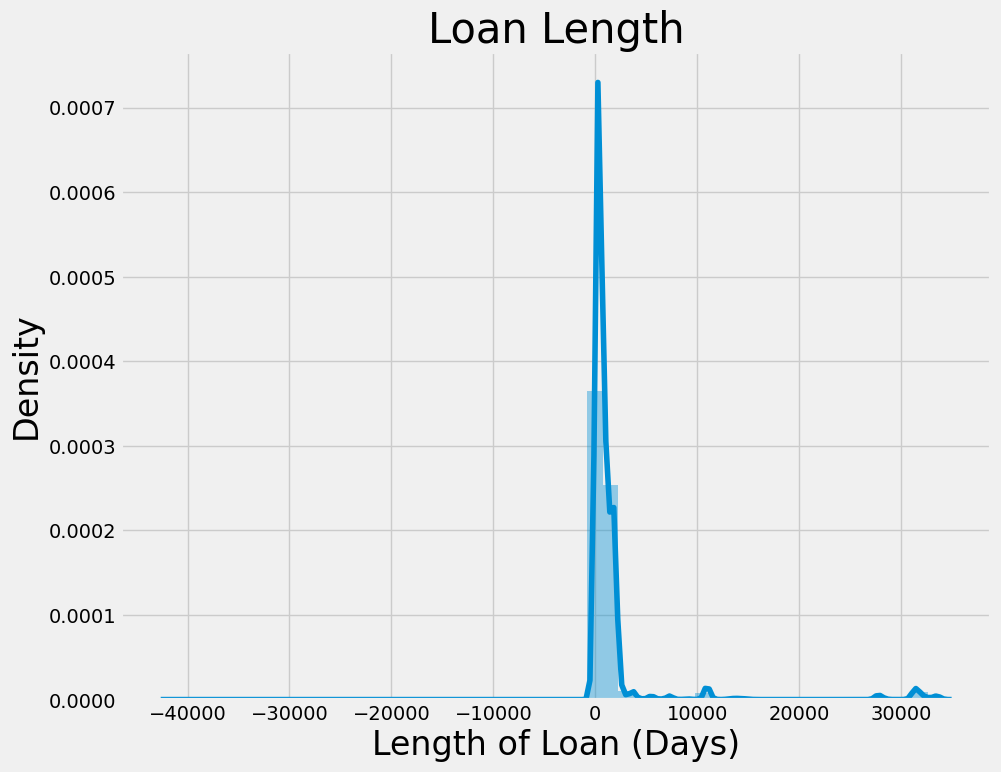

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

In [15]:
average_days_per_month = 30
bureau_balance['bureau_balance_date'] = start_date + pd.to_timedelta(bureau_balance['MONTHS_BALANCE'] * average_days_per_month, unit='D')
bureau_balance = bureau_balance.drop(columns=['MONTHS_BALANCE'])


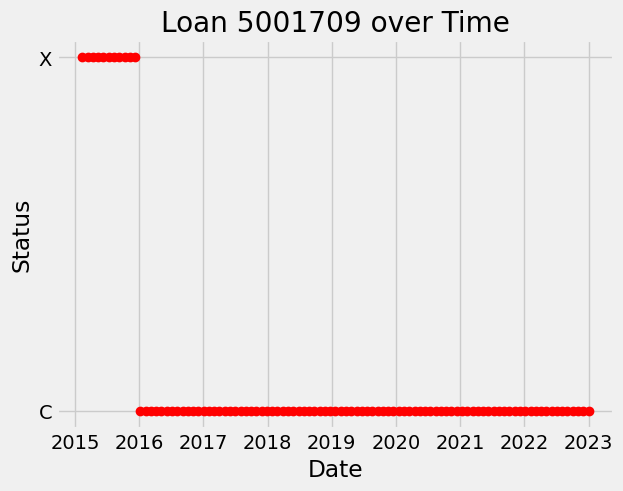

In [16]:
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro')
plt.title('Loan 5001709 over Time')
plt.xlabel('Date')
plt.ylabel('Status')
plt.show()

In [17]:
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

In [18]:
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

In [19]:
average_days_per_month = 30
credit['credit_balance_date'] = start_date + pd.to_timedelta(credit['MONTHS_BALANCE'] * average_days_per_month, unit='D')
cash['cash_balance_date'] = start_date + pd.to_timedelta(cash['MONTHS_BALANCE'] * average_days_per_month, unit='D')

# Drop the original 'MONTHS_BALANCE' column
credit = credit.drop(columns=['MONTHS_BALANCE'])
cash = cash.drop(columns=['MONTHS_BALANCE'])


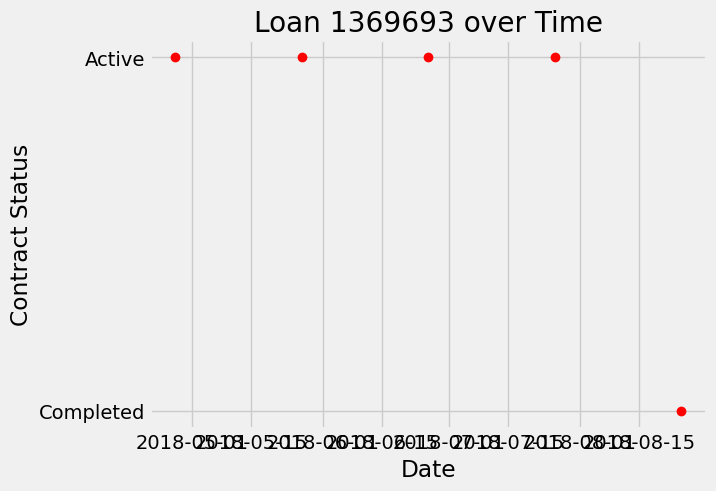

In [20]:
# Select one loan and plot for cash DataFrame
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro')
plt.title('Loan 1369693 over Time')
plt.xlabel('Date')
plt.ylabel('Contract Status')
plt.show()

In [21]:
cash[cash['SK_ID_PREV'] == 1369693]

,SK_ID_PREV,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,cash_balance_date
SK_ID_CURR,,,,,,,
100001,1369693,4.0,0.0,Completed,0,0,2018-08-25
100001,1369693,4.0,1.0,Active,0,0,2018-07-26
100001,1369693,4.0,4.0,Active,0,0,2018-04-27
100001,1369693,4.0,2.0,Active,0,0,2018-06-26
100001,1369693,4.0,3.0,Active,0,0,2018-05-27


In [22]:
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

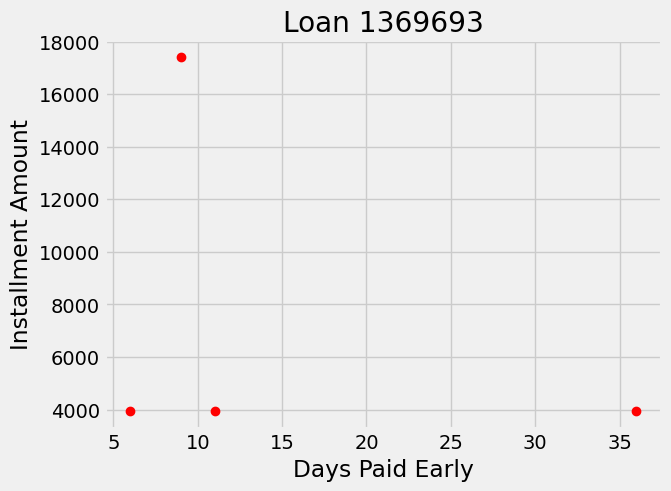

In [23]:
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

In [24]:
def create_partition(user_list, partition):
    """Creates and saves a dataset with only the users in `user_list`."""
    
    # Make the directory
    directory = './input/partitions/t%d' % (partition + 1)
    if os.path.exists(directory):
        return
    
    else:
        os.makedirs(directory)
        
        # Subset based on user list
        app_subset = app[app.index.isin(user_list)].copy().reset_index()
        bureau_subset = bureau[bureau.index.isin(user_list)].copy().reset_index()

        # Drop SK_ID_CURR from bureau_balance, cash, credit, and installments
        bureau_balance_subset = bureau_balance[bureau_balance.index.isin(user_list)].copy().reset_index(drop = True)
        cash_subset = cash[cash.index.isin(user_list)].copy().reset_index(drop = True)
        credit_subset = credit[credit.index.isin(user_list)].copy().reset_index(drop = True)
        previous_subset = previous[previous.index.isin(user_list)].copy().reset_index()
        installments_subset = installments[installments.index.isin(user_list)].copy().reset_index(drop = True)
        
        
        # Save data to the directory
        app_subset.to_csv('%s/app.csv' % directory, index = False)
        bureau_subset.to_csv('%s/bureau.csv' % directory, index = False)
        bureau_balance_subset.to_csv('%s/bureau_balance.csv' % directory, index = False)
        cash_subset.to_csv('%s/cash.csv' % directory, index = False)
        credit_subset.to_csv('%s/credit.csv' % directory, index = False)
        previous_subset.to_csv('%s/previous.csv' % directory, index = False)
        installments_subset.to_csv('%s/installments.csv' % directory, index = False)

        if partition % 10 == 0:
            print('Saved all files in partition {} to {}.'.format(partition + 1, directory))

In [25]:
# Break into 104 chunks
chunk_size = app.shape[0] // 103

# Construct an id list
id_list = [list(app.iloc[i:i+chunk_size].index) for i in range(0, app.shape[0], chunk_size)]

In [26]:
import os 

for i, ids in enumerate(id_list):
    # Create a partition based on the ids
    create_partition(ids, i)

Saved all files in partition 1 to ./input/partitions/t1.
Saved all files in partition 11 to ./input/partitions/t11.
Saved all files in partition 21 to ./input/partitions/t21.
Saved all files in partition 31 to ./input/partitions/t31.
Saved all files in partition 41 to ./input/partitions/t41.
Saved all files in partition 51 to ./input/partitions/t51.
Saved all files in partition 61 to ./input/partitions/t61.
Saved all files in partition 71 to ./input/partitions/t71.
Saved all files in partition 81 to ./input/partitions/t81.
Saved all files in partition 91 to ./input/partitions/t91.
Saved all files in partition 101 to ./input/partitions/t101.


In [27]:
#!rm -rf ./input/partitions